### ASTR 8070: Astrostatistics
***N. Pol***
___

# Homework 5
### Due: Friday, Mar 7nd at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data_1.npy`. This is a (100 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

### Solution

<>:7: SyntaxWarning: invalid escape sequence '\h'
<>:7: SyntaxWarning: invalid escape sequence '\h'
C:\Users\tonyt\AppData\Local\Temp\ipykernel_3480\2653571625.py:7: SyntaxWarning: invalid escape sequence '\h'
  data = np.hsplit(np.load('hw_data\hw5_data_1.npy'), 3) #Pulling in data


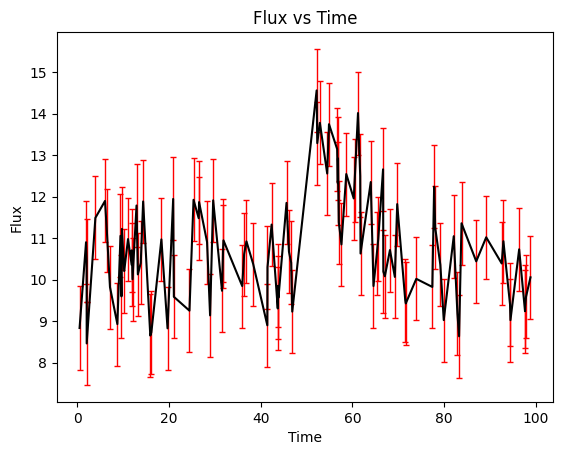

In [ ]:
#Part 1
import numpy as np
import matplotlib.pyplot as plt
import scipy

data = np.hsplit(np.load('hw_data\hw5_data_1.npy'), 3) #Pulling in data
time = data[0].transpose()[0] #Im sure there is an easier way, but I got this working first.
flux = data[1].transpose()[0]
sigma = data[2].transpose()[0]
#print(np.shape(time), np.shape(flux), np.shape(sigma))

plt.title("Flux vs Time")
plt.xlabel("Time")
plt.ylabel("Flux")
_ = plt.errorbar(time,flux, yerr=sigma, ecolor="red", c = 'black', capsize=2, elinewidth=1)


-4397.350989423355


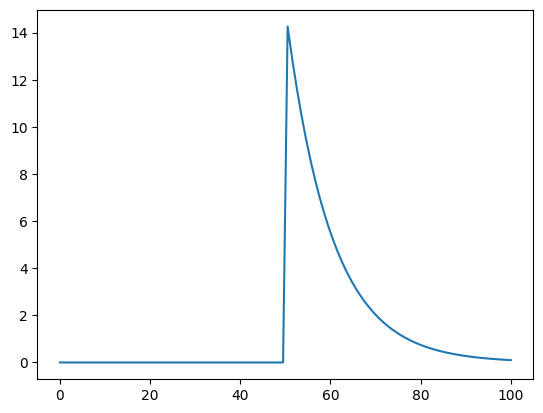

In [ ]:
#Part 2
def function(params, t): #Function to form the model
    t0, b, A, a = params #assigning these to a variable so I dont have to keep typing them.
    y = np.zeros(len(t))
    for i in range(len(t)):
        if t[i] < t0:
            y[i] = b
        else: y[i] = b + A * np.exp(-a * (t[i] - t0))
    return y

def likelihood(params, t, y, err):
    model = function(params, t)
    return np.sum(((y-model)/err)**2)*-.5

xgrid = np.linspace(0,100,100)

y     = function([50, 0, 15, 0.1], xgrid) #Forming the model for my data.

print(likelihood([50, 0, 15, 0.1], time, flux, sigma))
_ = plt.plot(xgrid, y)

In [ ]:
#Part 3
import emcee

def logPrior(params):
    t0, b, A, a = params
    if 0 < t0 < 100 and 0 < b < 50 and 0 < A < 50 and -5 < a < 5: #Trimming out what will not fit
        return 0
    return -np.inf

def logProb(params, t, y, err):
    prior = logPrior(params)
    if prior == -np.inf:
        return -np.inf
    return prior + likelihood(params, t, y, err)

ndim = 4
walkers = 32
guess = [[np.random.uniform(0,50), np.random.uniform(0,50), np.random.uniform(0,100), np.random.uniform(-5,5)]
        for _ in range(walkers)]
sampler = emcee.EnsembleSampler(walkers, ndim, logProb, args=(time, flux, sigma))
_ = sampler.run_mcmc(guess, 50000, progress = True)
#I am not confident this modeling is correct, as it took significantly longer than I feel it should have
#just for these 50000 steps.

C:\Users\tonyt\AppData\Local\Temp\ipykernel_3480\1597195179.py:14: RuntimeWarning: overflow encountered in square
  return np.sum(((y-model)/err)**2)*-.5
100%|██████████| 50000/50000 [03:31<00:00, 236.76it/s]


In [ ]:
#Part 4

tau = sampler.get_autocorr_time(tol=0)
print("Time: ", tau)
burn_in = int(2*np.max(tau))
thin = int(np.max(tau))
samples = sampler.get_chain(discard=burn_in, thin=thin, flat=True)
print("Samples: ", len(samples)) #I think this is almost certainly too low of a sample count

Time:  [320.56424191 129.12245576 388.08266242 553.12514324]
Samples:  2816


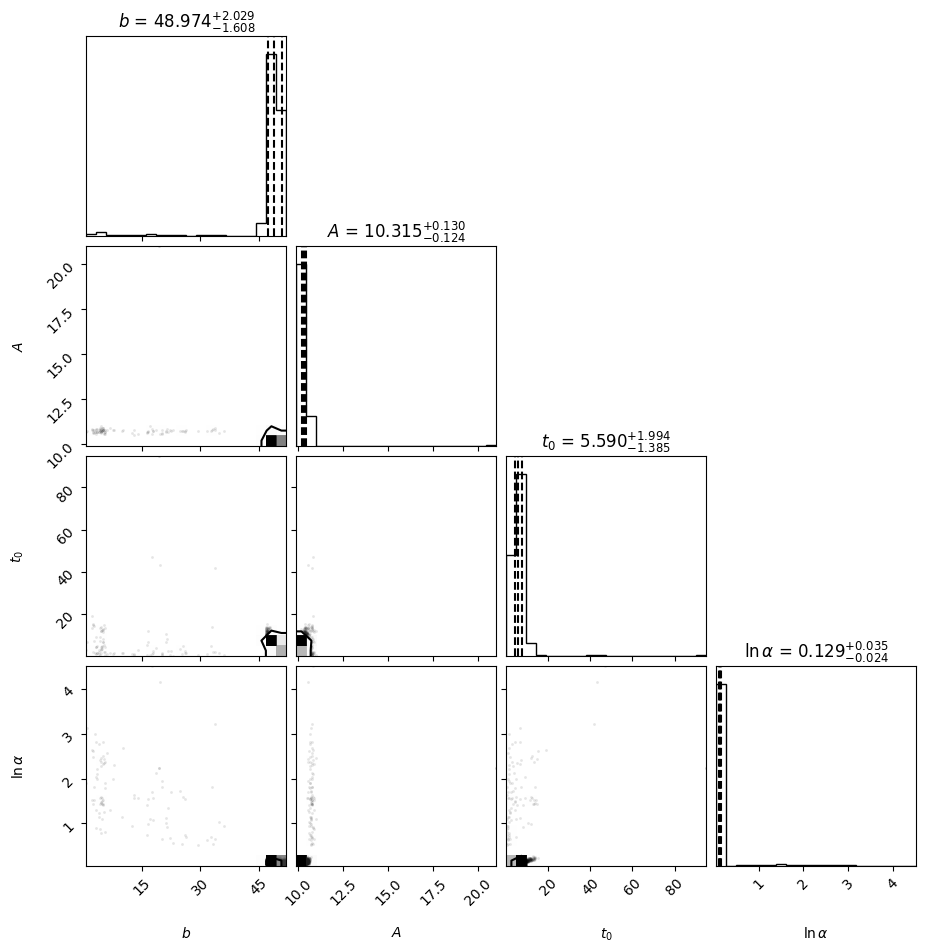

In [ ]:
#Part 5
import corner

fig = corner.corner(
    samples,
    labels       = [r"$b$", r"$A$", r"$t_0$", r"$\ln \alpha$"],
    levels       = (0.68, 0.95),
    show_titles  = True,
    title_kwargs = {"fontsize": 12},
    quantiles    = [0.16, 0.50, 0.84],
    title_fmt    = ".3f"
)
#By how poorly these plots came out, and the warning the package gave me, I have to assume the quality
#of these plots has to be due to my relatively low sample count. But I can also accept that it is due
#to an error in my code.
plt.show()

Text(0, 0.5, 'Flux')

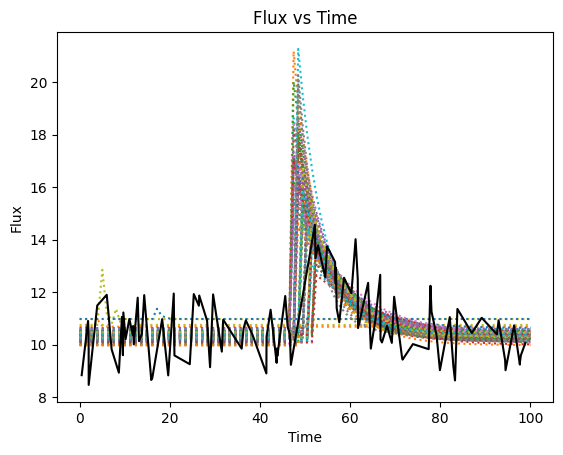

In [ ]:
#Part 6

draw = np.random.randint(0, len(samples[::,0]), size = 100) #chosing 100 random indices for my models.
why = []
for i in draw:
    why.append(int(i))

    xgrid = np.linspace(0,100,100)

    values = samples[::,:][i] #pulling my constants out
    t0 = values[0]
    b  = values[1]
    A  = values[2]
    a  = values[3]

    point = function(values, xgrid)
    plt.plot(xgrid, point, ls = ':') #plotting 100 variations of this model

plt.plot(time, flux, c = "black")
plt.title("Flux vs Time")
plt.xlabel("Time")
plt.ylabel("Flux")

#Part 7

Alright, i'll be pefectly honest here. Its 11:30, and there is no chance i can get this done without just looking things up.